In [ ]:
# 本文件用于使用训练好的模型预测流场
import pickle
from utils.train_functions import *
from utils.functions import *
from model.UNetEx import UNetEx
import configparser

config = configparser.ConfigParser()
config.read("./config/config.ini")

In [2]:
# 设置卷积核大小
kernel_size = int(config["net_parameter"]["kernel_size"])
# 设置卷积层channel数目
filters = [int(i) for i in config["net_parameter"]["filters"].split(",")]
# 设置batch_norm和weight_norm
bn = bool(int(config["net_parameter"]["batch_norm"]))
wn = bool(int(config["net_parameter"]["weight_norm"]))
# 构建模型
model = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
# 加载模型参数
model.set_state_dict(
        paddle.load(os.path.join(config["path"]["save_path"], config["path"]["model_name"])))

# 加载数据集并处理
x = pickle.load(open(os.path.join(config["path"]["data_path"], "dataX.pkl"), "rb"))
y = pickle.load(open(os.path.join(config["path"]["data_path"], "dataY.pkl"), "rb"))
x = paddle.to_tensor(x, dtype="float32")
y = paddle.to_tensor(y, dtype="float32")
y_trans = paddle.transpose(y, perm=[0, 2, 3, 1])
channels_weights = paddle.reshape(
    paddle.sqrt(paddle.mean(paddle.transpose(y, perm=[0, 2, 3, 1]).reshape((981 * 172 * 79, 3)) ** 2, axis=0)),
    shape=[1, -1, 1, 1])

# 按7：3的比例分割数据集，7为训练集，3为测试集
train_data, test_data = split_tensors(x, y, ratio=float(config["hyperparameter"]["train_test_ratio"]))

train_dataset, test_dataset = paddle.io.TensorDataset([train_data[0], train_data[1]]), paddle.io.TensorDataset(
    [test_data[0], test_data[1]])
test_x, test_y = test_dataset[:]

W0803 10:36:22.254525 27851 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0803 10:36:22.259187 27851 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


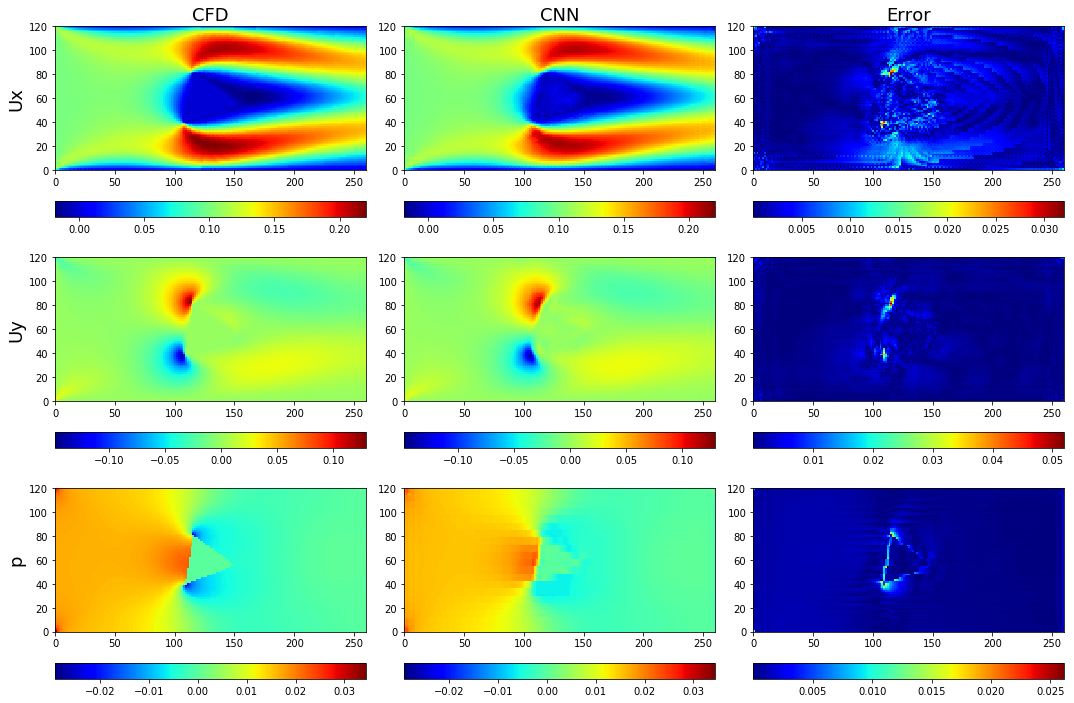

In [14]:
# 测试训练模型
out = model(test_x)
# 计算残差
error = paddle.abs(out.cpu() - test_y.cpu())
# 作出CFD和CNN的计算结果对比图以及对应的残差图(s可修改)
s = 0
visualize(test_y.detach().numpy(), out.detach().numpy(), error.detach().numpy(), s)